### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import euclidean, cdist
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

In [2]:
sim_data = pd.read_csv('./cluster_data/sim_new_xray.csv')

In [3]:
len(np.unique(sim_data['name']))

15248

In [4]:
sim_df_clean = sim_data.copy(deep=True).fillna({'main_type': 'NaN'})

In [5]:
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

features_lognorm = ['bb_kt', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

features_norm = ['powlaw_gamma']

X = sim_df_clean.copy(deep=True).to_numpy()

In [6]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [7]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(sim_df_clean, X, feature, True)
        
for feature in features_norm:
    X = lognorm(sim_df_clean, X, feature, False)

In [8]:
s_df = pd.DataFrame(X, columns=sim_df_clean.columns)

In [9]:
def Mahalanobis(x, covariance_matrix, mean):

    x = np.array(x)
    mean = np.array(mean)
    covariance_matrix = np.array(covariance_matrix)

    t1 = (x-mean)
    #print(f'Term 1 {t1}')

    icov = np.linalg.inv(covariance_matrix)
    #print(f'Inverse covariance {icov}')

    t2 = (x.transpose()-mean.transpose())
    #print(f'Term 2 {t2}')

    mahal = t1.dot(icov.dot(t2))

    #return (x-mean)*np.linalg.inv(covariance_matrix).dot(x.transpose()-mean.transpose())
    return mahal

In [10]:
def create_summary_tables(df):
    data_n = df.copy(deep=True)
    count_obs = data_n.groupby(['main_type']).size()
    df_n = pd.concat([count_obs], axis=1)
    df_n = df_n.rename(columns={0:'size'})
    return df_n

def softmin(x):
    return np.exp(-np.abs(x))/sum(np.exp(-np.abs(x)))
    
def frequent_types(df, n, uks):
    if uks:
        df = df[(df.main_type != 'NaN') & ~(df.main_type.isin(uks))]
    else:
        df = df[df.main_type != 'NaN']
    count_obs = df.groupby(['main_type']).size()
    count_obs_df = count_obs.reset_index()
    count_obs_df = count_obs_df.rename(columns={0:'size'})
    quer = count_obs_df.sort_values(by='size', ascending=False).head(n)
    ltypes = np.unique(quer.main_type)
    return ltypes

def gen_nan_probs(cl, features, ltypes_in=[], uks=[], mean=True, distance='mahalanobis', predominants='cluster', num_pred=5):
    if uks:
        cl_nan = cl[(cl.main_type == 'NaN') | cl.main_type.isin(uks)]
    else:
        cl_nan = cl[cl.main_type == 'NaN']
        
    if predominants=='cluster':
        ltypes = ltypes = frequent_types(s_df, num_pred, uks=uks)
    elif predominants=='general':
        ltypes = ltypes_in

    cl_types_desc = cl_nan[features]
    types_comp = []
    types_prob = []
    final_types = []
    first = True
    for i, row in cl_types_desc.iterrows():
        r_np = row.to_numpy().reshape(1, -1)
        
        mdists = []
        for t in ltypes:
            cl_type = cl[cl.main_type == t]
            cl_type_desc = cl_type[features]
            cltd_np = cl_type_desc.to_numpy()
            
            if cltd_np.shape[0] < len(features):
                continue
            if first:
                final_types.append(t)
                
            if distance == 'euclidean':
                d2t = cdist(r_np, cltd_np, metric='euclidean')
            elif distance == 'mahalanobis':
                #print(cltd_np.astype(float))
                V = np.cov(cltd_np.astype(float).T)
                
                IV = np.linalg.inv(V)
                
                mean_cltd = np.mean(cltd_np)
                
                #d2t = Mahalanobis(r_np, IV, mean_cltd)
                d2t = cdist(r_np, cltd_np, metric='mahalanobis', VI=IV)
            
            if mean:
                d2t_mean = np.mean(d2t)
            else:
                d2t_mean = np.median(d2t)

            mdists.append(d2t_mean)
        if first:
            first = False
        mdistsn = np.asarray(mdists).reshape(-1, 1)
        mdistsn = mdistsn.ravel()
        sm_probs = softmin(mdistsn)
        types_prob.append(sm_probs)
        t_amax = np.argmax(sm_probs)
        types_comp.append(final_types[t_amax])

    #print(cl_nan.name.to_numpy(), np.array(types_prob), types_comp)
    out_l = pd.DataFrame(cl_nan[['name', 'obsid'] + features])
    out_l['main_type'] = types_comp
    for i, t in enumerate(final_types):
        tarray_probs = np.vstack(types_prob)
        out_l[t] = tarray_probs[:, i]
        
    return out_l

In [11]:
# Dropping all NaNs and dummy classes
def process_data_for_validation(data, types, uks):
    if uks:
        df = data[(data.main_type != 'NaN') & ~(data.main_type.isin(uks))]
    else:
        df = data[data.main_type != 'NaN']
    df = df.loc[df['main_type'].isin(types)]
    return df

[('AGN', 728), ('HMXB', 727), ('LMXB', 728), ('Orion_V*', 728), ('QSO', 728), ('Seyfert_1', 728), ('Seyfert_2', 728), ('TTau*', 728), ('XB', 727), ('YSO', 728)]


C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


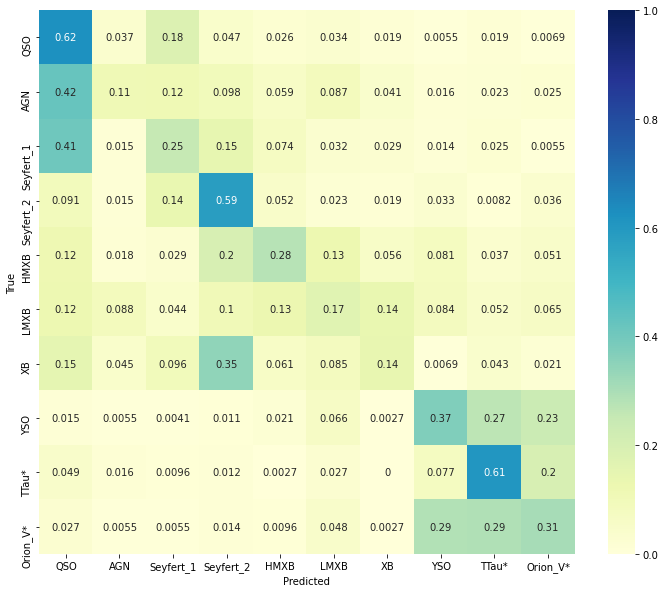

In [70]:
#### Experiment with normal classifier

from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(data_clean, data_clean.main_type)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

from collections import Counter
print(sorted(Counter(y_test).items()))

clf = LinearSVC(max_iter=3000)
clf.fit(X_train[features], y_train)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/raw_supervised_balanced.png', bbox_inches='tight')

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


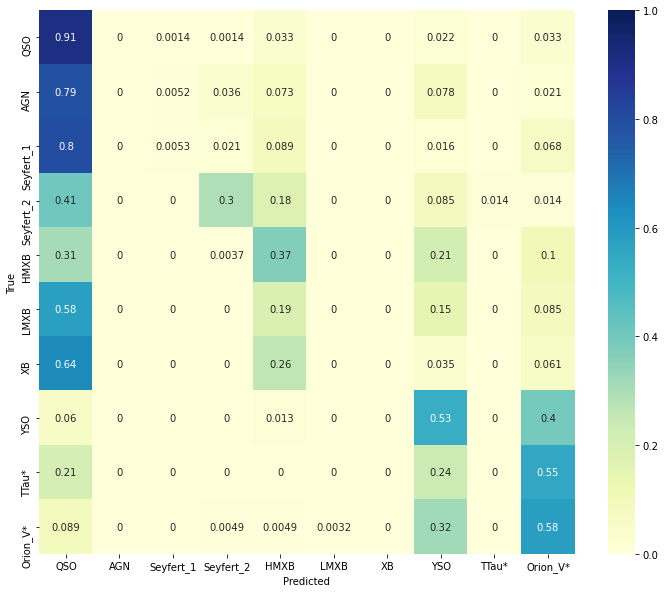

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.3, stratify=data_clean.main_type, random_state=42)

clf = LinearSVC(max_iter=3000)
clf.fit(X_train[features], y_train)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/raw_supervised_unbalanced.png', bbox_inches='tight')

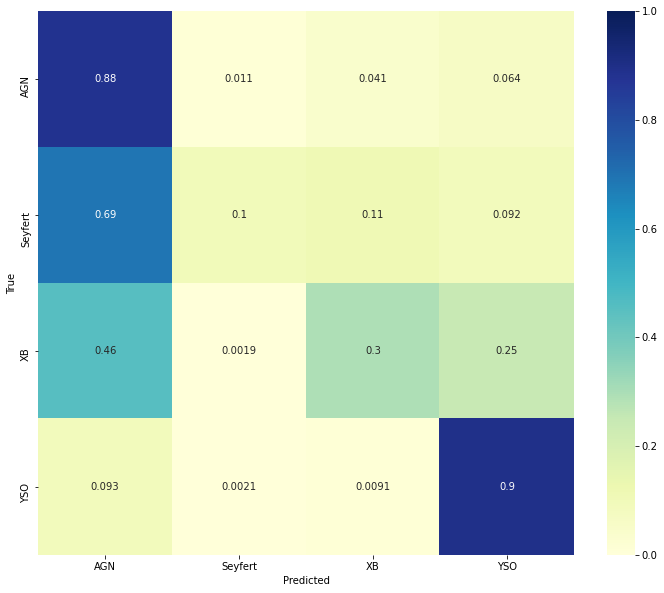

In [74]:
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
y_test_certain_grouped = y_test.replace(grouped_replace)
pred_class_certain_grouped = pd.DataFrame(clf.predict(X_test[features])).replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/raw_supervised_unbalanced_grouped.png', bbox_inches='tight')

### Selected classes

In [46]:
uks = ['Star', 'X', 'Unknown']
ltypes = ['QSO', 'AGN', 'Seyfert_1', 'Seyfert_2', 'HMXB', 'LMXB', 'XB', 'YSO', 'TTau*', 'Orion_V*']
data_clean = process_data_for_validation(s_df, ltypes, uks=uks)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.3, stratify=data_clean.main_type, random_state=42)
y_test_sorted = X_test.sort_values(by=['name', 'obsid']).main_type
y_test_master = X_test.groupby(['name', 'main_type'], as_index=False).size()
y_test_master = y_test_master
X_test.loc[:,'main_type'] = 'NaN'

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [48]:
X_train.shape

(7326, 97)

In [49]:
X_test.shape

(3141, 97)

In [50]:
from collections import Counter
print(sorted(Counter(data_clean.main_type).items()))

[('AGN', 644), ('HMXB', 903), ('LMXB', 509), ('Orion_V*', 2057), ('QSO', 2426), ('Seyfert_1', 632), ('Seyfert_2', 237), ('TTau*', 632), ('XB', 380), ('YSO', 2047)]


In [23]:
pred_class = []
for cl_i in range(6):
    X_train_cl = X_train[X_train.cluster == cl_i]
    X_test_cl = X_test[X_test.cluster == cl_i]
    test_cl_class = gen_nan_probs(pd.concat([X_train_cl, X_test_cl]), features, ltypes, uks=uks, mean=True, distance='mahalanobis', predominants='general')
    pred_class.append(test_cl_class)
    
pred_class_df = pd.concat(pred_class)

In [24]:
pred_class_df.shape

(3141, 25)

#### Selecting high probabilities in classification

In [54]:
pred_class_df.sort_values(by=['name', 'obsid'], inplace=True)
prob_mask = pred_class_df.iloc[:,pred_class_df.columns.get_loc('main_type')+1:-2].max(axis=1) > 0.4
pred_class_certain = pred_class_df[prob_mask.to_numpy()]
y_test_certain = y_test_sorted[prob_mask.to_numpy()]

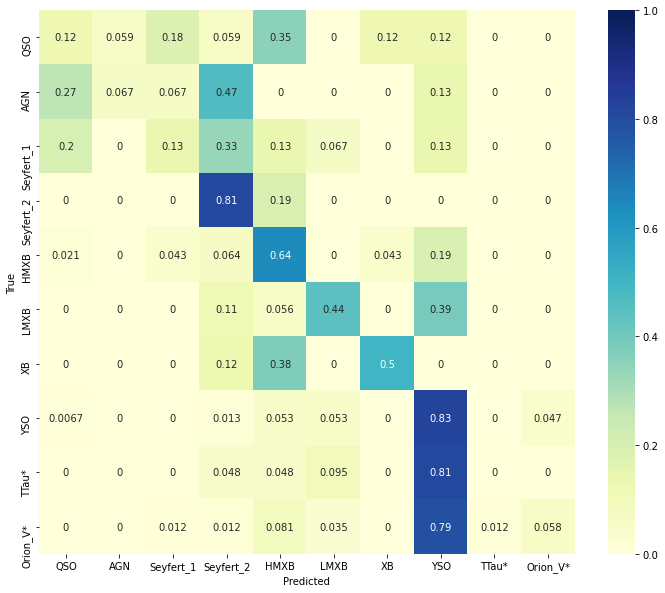

In [55]:
cf_matrix = confusion_matrix(y_test_certain, pred_class_certain.main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/high_probabilities.png', bbox_inches='tight')

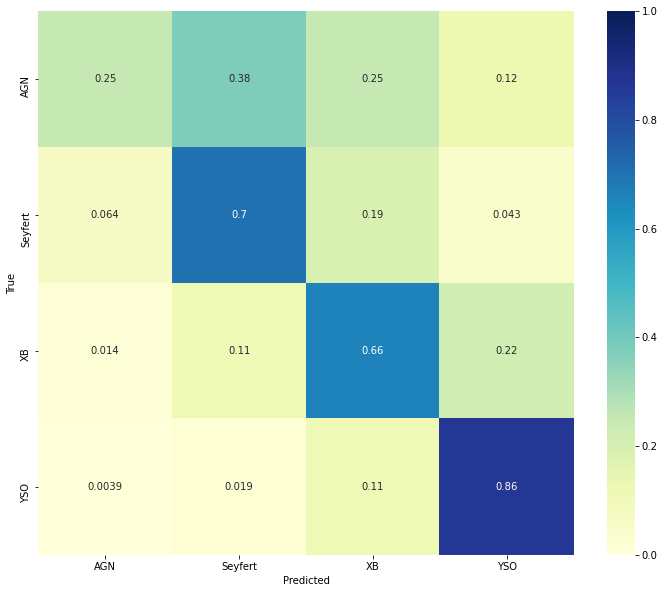

In [64]:
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
y_test_certain_grouped = y_test_certain.replace(grouped_replace)
pred_class_certain_grouped = pred_class_certain.main_type.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/high_probabilities_grouped.png', bbox_inches='tight')

#### Taking the raw test set

In [65]:
print(classification_report(y_test_sorted, pred_class_df.sort_values(by=['name', 'obsid']).main_type))

              precision    recall  f1-score   support

         AGN       0.16      0.19      0.18       193
        HMXB       0.35      0.46      0.39       271
        LMXB       0.21      0.23      0.22       153
    Orion_V*       0.51      0.45      0.47       617
         QSO       0.67      0.37      0.48       728
   Seyfert_1       0.22      0.36      0.28       190
   Seyfert_2       0.26      0.49      0.34        71
       TTau*       0.29      0.39      0.34       190
          XB       0.31      0.28      0.29       114
         YSO       0.47      0.50      0.48       614

    accuracy                           0.40      3141
   macro avg       0.35      0.37      0.35      3141
weighted avg       0.45      0.40      0.41      3141



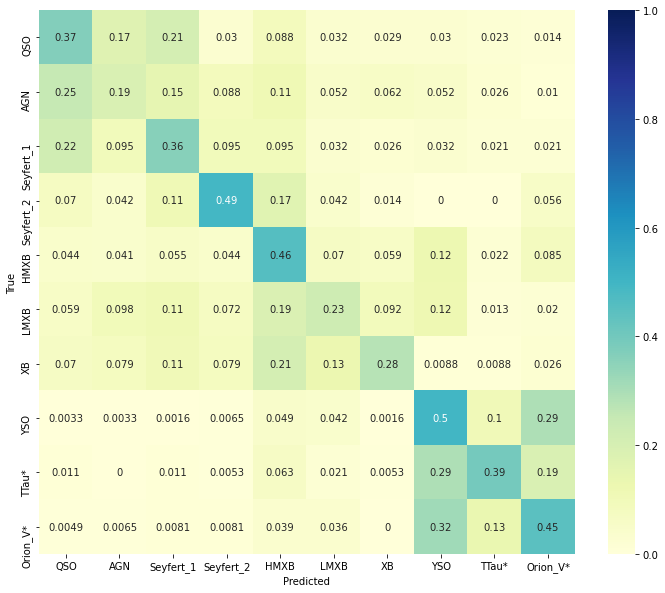

In [66]:
cf_matrix = confusion_matrix(y_test_sorted, pred_class_df.sort_values(by=['name', 'obsid']).main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/raw.png', bbox_inches='tight')

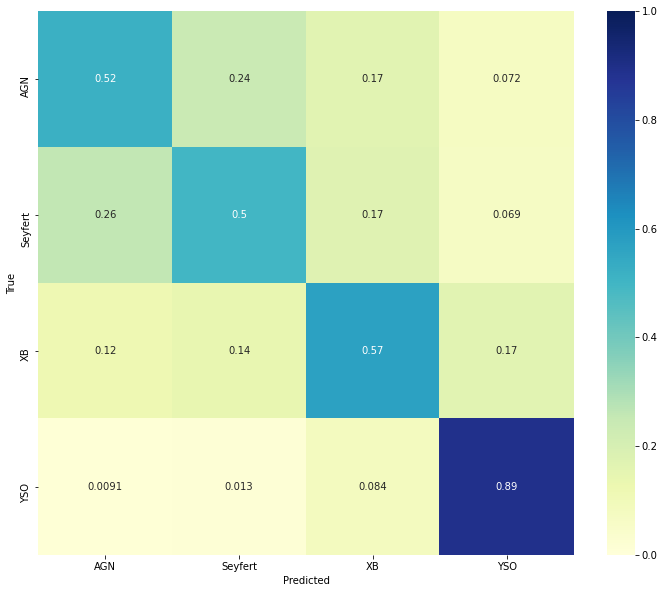

In [67]:
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
y_test_certain_grouped = y_test_sorted.replace(grouped_replace)
pred_class_certain_grouped =  pred_class_df.sort_values(by=['name', 'obsid']).main_type.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/raw_grouped.png', bbox_inches='tight')

#### Predominance with mean probabilities over observations

In [30]:
classes_names = pred_class_df.iloc[:,pred_class_df.columns.get_loc('main_type')+1:-2].columns
pred_class_df.fillna(0, inplace=True)
summ_table = pred_class_df.groupby('name')[classes_names].agg(['mean', 'std'])
summ_table['count'] = pred_class_df.groupby(['name']).size()
class_mean_names = [list(tup) for tup in itertools.product(classes_names, ['mean'], repeat=1)]
names_comp = summ_table[class_mean_names].idxmax(axis=1).to_list()
master_names = [name[0] for name in names_comp]
summ_table['master_names'] = master_names

In [31]:
y_true = y_test_master.sort_values(by='name').main_type
y_pred = summ_table.sort_values(by='name').master_names

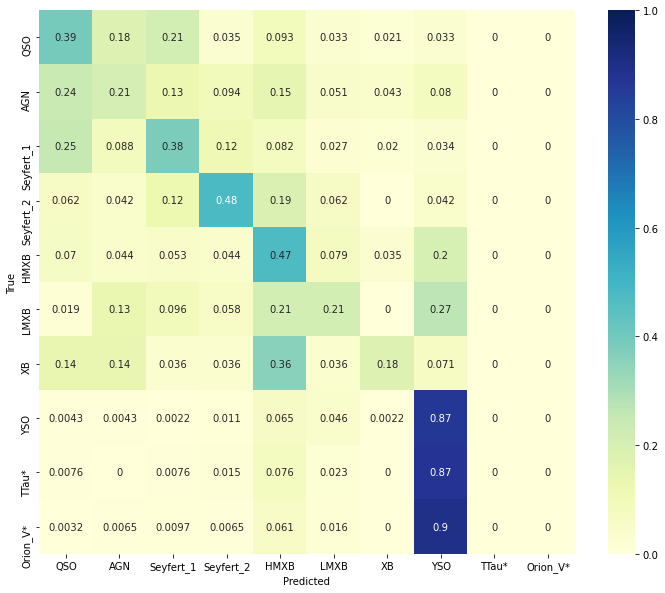

In [32]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/summary.png', bbox_inches='tight')

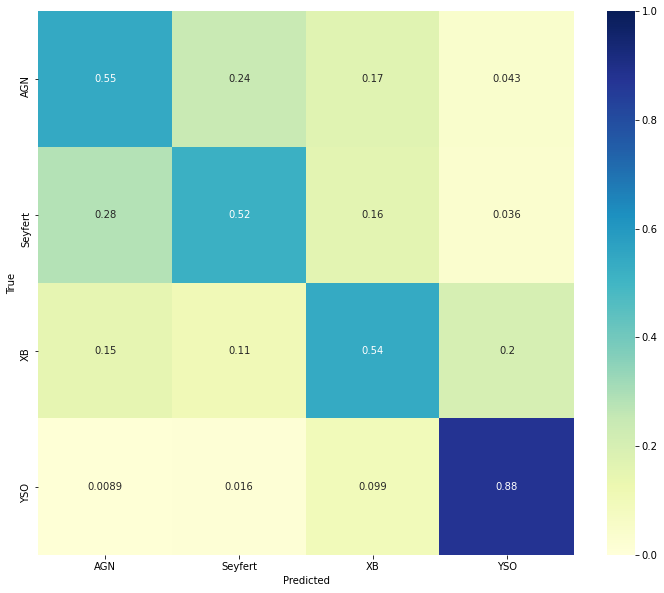

In [68]:
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
y_test_certain_grouped = y_true.replace(grouped_replace)
pred_class_certain_grouped =  y_pred.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./plots/summary_grouped.png', bbox_inches='tight')

### Cluster predominance

In [ ]:
ltypes = frequent_types(s_df, 12, uks=uks)
data_clean = process_data_for_validation(s_df, ltypes, uks=uks)
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.1, random_state=42)
y_test_sorted = X_test.sort_values(by=['name', 'obsid']).main_type
X_test.loc[:,'main_type'] = 'NaN'

In [ ]:
ltypes

In [ ]:
test_class = []
for cl_i in range(6):
    X_train_cl = X_train[X_train.cluster == cl_i]
    X_test_cl = X_test[X_test.cluster == cl_i]
    test_cl_class = gen_nan_probs(pd.concat([X_train_cl, X_test_cl]), features, ltypes, uks=uks, mean=True, distance='mahalanobis', predominants='cluster', num_pred=8)
    test_class.append(test_cl_class)
    
test_class_df = pd.concat(test_class)

In [ ]:
print(classification_report(y_test_sorted, test_class_df.sort_values(by=['name', 'obsid']).main_type))

In [ ]:
cf_matrix = confusion_matrix(y_test_sorted, test_class_df.sort_values(by=['name', 'obsid']).main_type, normalize='true')
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(cf_matrix, annot=True, xticklabels = np.unique(y_test_sorted), yticklabels = np.unique(y_test_sorted), ax=ax, vmin=0, vmax=0.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

### General predominance

In [ ]:
ltypes = frequent_types(s_df, 10, uks=uks)
data_clean = process_data_for_validation(s_df, ltypes, uks=uks)
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.1, random_state=42)
y_test_sorted = X_test.sort_values(by=['name', 'obsid']).main_type
X_test.loc[:,'main_type'] = 'NaN'

In [ ]:
test_class = []
for cl_i in range(6):
    X_train_cl = X_train[X_train.cluster == cl_i]
    X_test_cl = X_test[X_test.cluster == cl_i]
    test_cl_class = gen_nan_probs(pd.concat([X_train_cl, X_test_cl]), features, ltypes, uks=uks, mean=True, distance='mahalanobis', predominants='general')
    test_class.append(test_cl_class)
    
test_class_df = pd.concat(test_class)

In [ ]:
print(classification_report(y_test_sorted, test_class_df.sort_values(by=['name', 'obsid']).main_type))

In [ ]:
cf_matrix = confusion_matrix(y_test_sorted, test_class_df.sort_values(by=['name', 'obsid']).main_type, normalize='true')
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=0.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [ ]:
plt.figure(figsize=(20,10))
df_for_dist = s_df[(s_df.main_type != 'NaN') & ~(s_df.main_type.isin(uks))]
df_for_dist['main_type'].value_counts().plot.bar(color='black')